In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, fftpack, signal, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'MO-TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

In [10]:
alpha = 0.01

#### Functions

In [11]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [12]:
def get_metadata(mdata_dict, metadf):
    exp_meta = metadf[(
        (metadf['mouse_name'].str.contains(mdata_dict['exp'].mouse)) &
        (metadf['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata_dict['exp'].experiment_folder))))
    )].squeeze()
    
    ## Gets EEG_bad_chs, stim_currents, and PCI_stim ##
    try:
        EEG_bad_chs = mdata_dict['bad_chs']
    except KeyError:
        badchstr = exp_meta['EEG bad_channels'].replace(' ','')
        EEG_bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                EEG_bad_chs.append(int(char))
    currentstr = exp_meta['Current (uA)'].replace(' ','')
    stim_currents = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            stim_currents.append(char)
    if len(stim_currents) > 1:
        PCI_stim = stim_currents[1]
    elif len(currents_list) == 1:
        PCI_stim = stim_currents[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    return EEG_bad_chs, stim_currents, PCI_stim

In [13]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [14]:
def shuffledAUC(data_traces, data_time, AUCwindow=[0.0, 0.5], nshuff=1000):
    BLinds = np.nonzero((data_time > AUCwindow[0]) & (data_time < AUCwindow[1]))[0]
    Rinds = np.nonzero((data_time > -AUCwindow[1]) & (data_time < -AUCwindow[0]))[0]
    indsize = len(BLinds) + len(Rinds)

    shuffaucs = np.zeros((nshuff), dtype=float)
    for shuffi in range(nshuff):
        trialstarts = np.random.uniform(low=0, high=data_traces.shape[0] - indsize, size=data_traces.shape[2]).astype(int)
        shufftrials = np.zeros((indsize, data_traces.shape[1], data_traces.shape[2]), dtype=float)
        for triali, startind in enumerate(trialstarts):
            shufftrials[:,:,triali] = data_traces[startind:startind+indsize,:,triali]
        avgavg = np.mean(np.mean(shufftrials, axis=2), axis=1)
        shuffz = (avgavg - np.mean(avgavg[:len(BLinds)])) / np.std(avgavg[:len(BLinds)])
        shuffaucs[shuffi] = integrate.simps(np.abs(shuffz[len(BLinds):]), data_time[Rinds], axis=0, even='last')
    return shuffaucs

In [15]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

## Load subjects from file

In [16]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_CSD_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [17]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 586468
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and se

In [18]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\CTX_LFP-units'

### Test one subject

In [19]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
apply_car = True

celltype = 'RS'
time_bin = 0.01 # size of time bins (s), was 0.005 DM suggested longer to make it more comparable to LFP

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [20]:
group = 'MOs_deep'
mouse_num = '569073'

stim_area = group[:2]
stim_depth = group.split('_')[-1]
mdata = multi_sub_dict[group][mouse_num]
evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
mdata['data'] = {}
        
## Load unit info ##
fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))
#     continue

## Grab exp metadata from Zap_Zip-log_exp ##
bad_chs, currents_list, PCI_stim_amp = get_metadata(mdata, zzmetadata)
        
## Load stim log (includes running speed now) ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
event_window = all_unit_event_spikes['event_window']
bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
mdata['good_chs'] = GOOD_CHS

## Load LFP info and traces ##
with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
    LFPinfo = json.load(info_file)
LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
    
## Load region LFP traces ONLY for regions with units AND LFP ##
reg_allLFPtraces = {}
reg_allCSDtraces = {}
reg_unit_info = {}
for region in areas_of_interest.keys():
    regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
    if (len(regdf) > 8) and (region in LFPinfo.keys()):
        reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
        reg_allCSDtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedCSDtraces.npy'))
    else:
        print('  {}: n={:d} -> not enough units, excluding'.format(region, len(regdf)))
if len(reg_allLFPtraces) == 0:
    print('  Subject has no regions to analyze.\n')
#     continue

## Get event inds ##
all_event_inds = {}
for leveli, parami in zip(current_levels, currents_list):
    all_event_inds[leveli] = {}
    for statei in ['awake', 'anesthetized']:
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
        state_events = []
        for sweepi in sweeps:
            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
            if len(events) == 0:
                continue
            state_events.append(events)
        all_event_inds[leveli][statei] = np.concatenate(state_events)
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][substatei] = np.concatenate(state_events)

EEG_traces = {}
LFP_traces = {}
CSD_traces = {}
unit_traces = {}
for leveli, states_events in all_event_inds.items():
    EEG_traces[leveli] = {}
    LFP_traces[leveli] = {}
    CSD_traces[leveli] = {}
    unit_traces[leveli] = {}
    for statei, event_inds in states_events.items():
        LFP_traces[leveli][statei] = {}
        CSD_traces[leveli][statei] = {}
        unit_traces[leveli][statei] = {}

        ## Get evoked EEG traces ##
        event_traces = all_EEG_traces[:, :, event_inds]
        ## Apply common avg ##
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]

        for region in areas_of_interest.keys():
            ## Get evoked LFP traces ##
            if region in reg_allLFPtraces.keys():
                LFP_traces[leveli][statei][region] = [LFP_event_ts, reg_allLFPtraces[region][:, :, event_inds]]
                CSD_traces[leveli][statei][region] = [LFP_event_ts, reg_allCSDtraces[region][:, :, event_inds]]

            ## Get unit firing rates ##
            if region in reg_unit_info.keys():
                all_firing_rates = np.empty((len(timex), len(reg_unit_info[region]), len(event_inds))) * np.nan
                for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                    for ii, evi in enumerate(event_inds):
                        spikecounts, edges = np.histogram(all_unit_event_spikes['event_spikes'][uniti][evi], bins)
                        all_firing_rates[:, uni, ii] = spikecounts / time_bin
                unit_traces[leveli][statei][region] = [timex, all_firing_rates]

mdata['data']['EEG'] = EEG_traces
mdata['data']['LFP'] = LFP_traces
mdata['data']['CSD'] = CSD_traces
mdata['data']['unit_frs'] = unit_traces
print('Good CSD regions:')
print(mdata['CSD_regions'])

### After each subject, delete common variables ###
del stim_log
del all_EEG_traces, EEG_event_timestamps
del reg_allLFPtraces, LFP_event_ts, reg_allCSDtraces
del all_unit_event_spikes, unit_info, reg_unit_info
del EEG_traces, LFP_traces, CSD_traces, unit_traces

Good CSD regions:
['MO', 'ACA', 'SS', 'VIS', 'MO-TH']


### Make some data plots

Plot unit firing, LFP, and CSD traces for one area

<IPython.core.display.Javascript object>


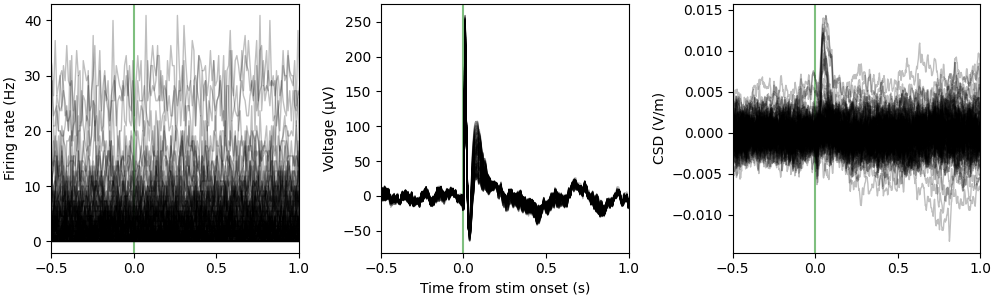

Text(0, 0.5, 'CSD (V/m)')

In [28]:
plot_stim_level = 'medium'
plot_state = 'awake'
plot_region = 'ACA'
twin = [-0.5, 1.0]

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, constrained_layout=True)

## Units ##
unit_time = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][0]
unit_traces = np.mean(mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][1], axis=2)
axs[0].axvline(0, color='g', alpha=0.5)
axs[0].plot(unit_time, unit_traces, color='k', linewidth=1, alpha=0.25)
axs[0].set_xlim([-0.5, 1.0])
# axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_ylabel('Firing rate (Hz)')

## LFP ##
ch_mask = np.array(LFPinfo[plot_region]['ch_mask'])
LFP_time = mdata['data']['LFP'][plot_stim_level][plot_state][plot_region][0]
LFP_traces = np.mean(mdata['data']['LFP'][plot_stim_level][plot_state][plot_region][1], axis=2)
axs[1].axvline(0, color='g', alpha=0.5)
axs[1].plot(LFP_time, LFP_traces[:,ch_mask], color='k', linewidth=1, alpha=0.25)
# axs[1].plot(LFP_time, LFP_traces[:,~ch_mask], color='r', linewidth=1, alpha=0.25)
axs[1].set_xlabel('Time from stim onset (s)')
axs[1].set_ylabel('Voltage (\u03bcV)')

## CSD ##
CSD_traces = np.mean(mdata['data']['CSD'][plot_stim_level][plot_state][plot_region][1], axis=2) / 10
axs[2].axvline(0, color='g', alpha=0.5)
axs[2].plot(LFP_time, CSD_traces, color='k', linewidth=1, alpha=0.25)
# axs[2].set_xlabel('Time from stim onset (s)')
axs[2].set_ylabel('CSD (V/m)')

Plot for all areas

Plot for all areas, with shuffling to determine significance of response

<IPython.core.display.Javascript object>


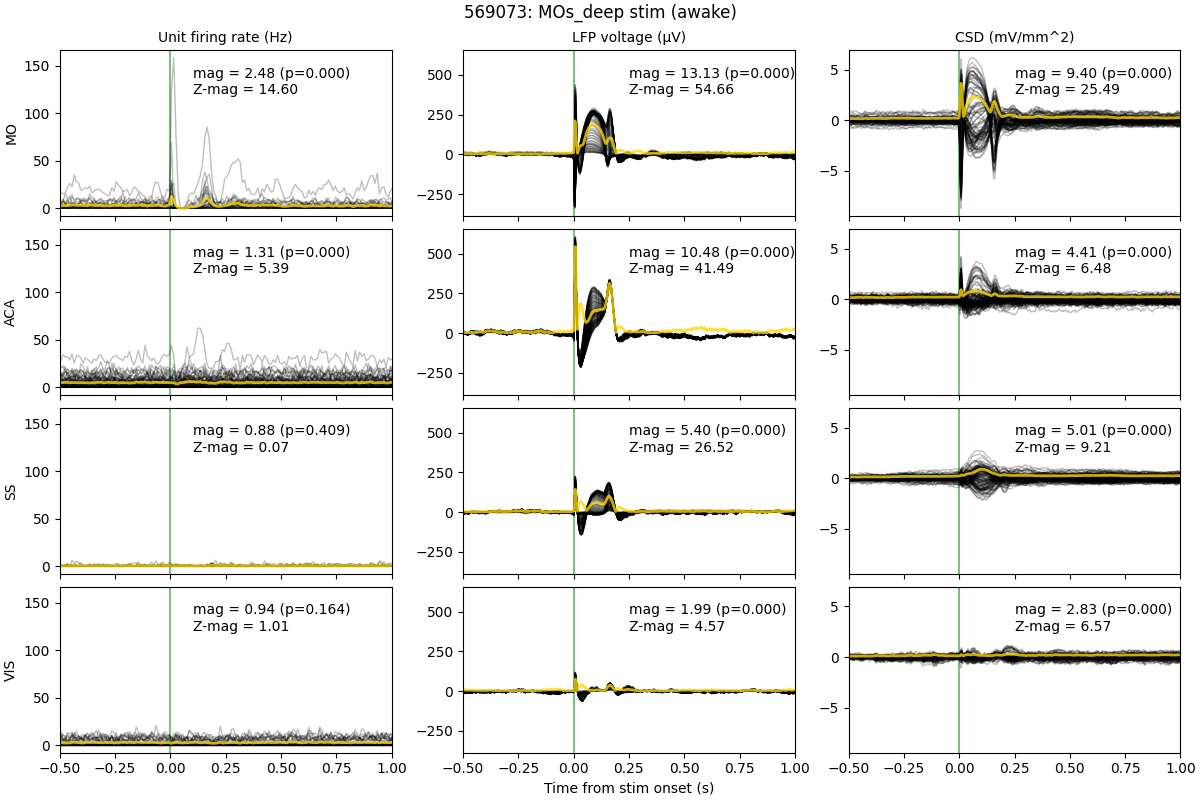

In [21]:
plot_stim_level = 'medium'
plot_state = 'awake'
twin = [-0.5, 1.0]
auc_window = [0.0, 1.0]
nshuffles = 1000

fig, axs = plt.subplots(len(ctx_regions), 3, figsize=(12, 8), sharex=True, sharey='col', constrained_layout=True)

for rowi, regi in enumerate(ctx_regions):
    if regi not in mdata['data']['unit_frs'][plot_stim_level][plot_state].keys():
        continue

    ## Units ##
    unit_time = mdata['data']['unit_frs'][plot_stim_level][plot_state][regi][0]
    units_alltrials = mdata['data']['unit_frs'][plot_stim_level][plot_state][regi][1]
    axs[rowi, 0].axvline(0, color='g', alpha=0.5)
    axs[rowi, 0].plot(unit_time, np.mean(units_alltrials, axis=2), color='k', linewidth=1, alpha=0.25)
    axs[rowi, 0].set_xlim([-0.5, 1.0])
    axs[rowi, 0].set_ylabel(regi)
    
    popFR = np.mean(np.mean(units_alltrials, axis=2), axis=1)
    axs[rowi, 0].plot(unit_time, popFR, color='gold', linewidth=2, alpha=0.8)
    
    pop_zscore = (popFR - np.mean(popFR[unit_time < 0])) / np.std(popFR[unit_time < 0])
    uinds = np.nonzero((unit_time > auc_window[0]) & (unit_time < auc_window[1]))[0]
    unitauc = integrate.simps(np.abs(pop_zscore)[uinds], unit_time[uinds], axis=0, even='last')
    unit_shuffauc = shuffledAUC(units_alltrials, unit_time, AUCwindow=auc_window, nshuff=nshuffles)
    unit_p = np.sum(unit_shuffauc > unitauc) / nshuffles
    Zunitauc = (unitauc - np.mean(unit_shuffauc)) / np.std(unit_shuffauc)
    axs[rowi, 0].annotate(
        'mag = {:.2f} (p={:.3f})\nZ-mag = {:.2f}'.format(unitauc, unit_p, Zunitauc), xy=(0.4, 0.9), xycoords='axes fraction',
        fontsize=10, ha='left', va='top'
    )
    
    
    ## LFP ##
    ch_mask = np.array(LFPinfo[regi]['ch_mask'])
    LFP_time = mdata['data']['LFP'][plot_stim_level][plot_state][regi][0]
    allLFP_alltrials = mdata['data']['LFP'][plot_stim_level][plot_state][regi][1][:,ch_mask,:]
    axs[rowi, 1].axvline(0, color='g', alpha=0.5)
    axs[rowi, 1].plot(LFP_time, np.mean(allLFP_alltrials, axis=2), color='k', linewidth=1, alpha=0.25)
    
    pop_LFP = np.mean(np.abs(np.mean(allLFP_alltrials, axis=2)), axis=1)
    axs[rowi, 1].plot(LFP_time, pop_LFP, color='gold', linewidth=2, alpha=0.8)
    
    pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_time < 0])) / np.std(pop_LFP[LFP_time < 0])
    lfpinds = np.nonzero((LFP_time > auc_window[0]) & (LFP_time < auc_window[1]))[0]
    lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_time[lfpinds], axis=0, even='last')
    lfp_shuffauc = shuffledAUC(allLFP_alltrials, LFP_time, AUCwindow=auc_window, nshuff=nshuffles)
    lfp_p = np.sum(lfp_shuffauc > lfpauc) / nshuffles
    Zlfpauc = (lfpauc - np.mean(lfp_shuffauc)) / np.std(lfp_shuffauc)
    axs[rowi, 1].annotate(
        'mag = {:.2f} (p={:.3f})\nZ-mag = {:.2f}'.format(lfpauc, lfp_p, Zlfpauc), xy=(0.5, 0.9), xycoords='axes fraction',
        fontsize=10, ha='left', va='top'
    )
    

    ## CSD ##
    if regi in mdata['CSD_regions']:
        allCSD_alltrials = - mdata['data']['CSD'][plot_stim_level][plot_state][regi][1] * 10 # units will be mV/mm^2
        axs[rowi, 2].axvline(0, color='g', alpha=0.5)
        axs[rowi, 2].plot(LFP_time, np.mean(allCSD_alltrials, axis=2), color='k', linewidth=1, alpha=0.25)

        pop_CSD = np.mean(np.abs(np.mean(allCSD_alltrials, axis=2)), axis=1)
        axs[rowi, 2].plot(LFP_time, pop_CSD, color='gold', linewidth=2, alpha=0.8)
        
        pop_CSD_zscore = (pop_CSD - np.mean(pop_CSD[LFP_time < 0])) / np.std(pop_CSD[LFP_time < 0])
        csdauc = integrate.simps(np.abs(pop_CSD_zscore)[lfpinds], LFP_time[lfpinds], axis=0, even='last')
        csd_shuffauc = shuffledAUC(allCSD_alltrials, LFP_time, AUCwindow=auc_window, nshuff=nshuffles)
        csd_p = np.sum(csd_shuffauc > csdauc) / nshuffles
        Zcsdauc = (csdauc - np.mean(csd_shuffauc)) / np.std(csd_shuffauc)
        axs[rowi, 2].annotate(
            'mag = {:.2f} (p={:.3f})\nZ-mag = {:.2f}'.format(csdauc, csd_p, Zcsdauc), xy=(0.5, 0.9), xycoords='axes fraction',
            fontsize=10, ha='left', va='top'
        )
        
    
    if rowi == 0:
        axs[rowi, 0].set_title('Unit firing rate (Hz)')
        axs[rowi, 1].set_title('LFP voltage (\u03bcV)')
        axs[rowi, 2].set_title('CSD (mV/mm^2)')
        
axs[rowi, 1].set_xlabel('Time from stim onset (s)')
plt.suptitle('{}: {} stim ({})'.format(mouse_num, group, plot_state))

## Save ##
figname = 'mag_FR-LFP-CSD_{}-{}_{}-{}.png'.format(group, mouse_num, plot_state, plot_stim_level)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Plot w/ paired t-test

You should find the population average firing rate BEFORE you baseline z-score. Finding the zscore firing rate/neuron then averaging across the population gives very low z values, for some reason.

<IPython.core.display.Javascript object>


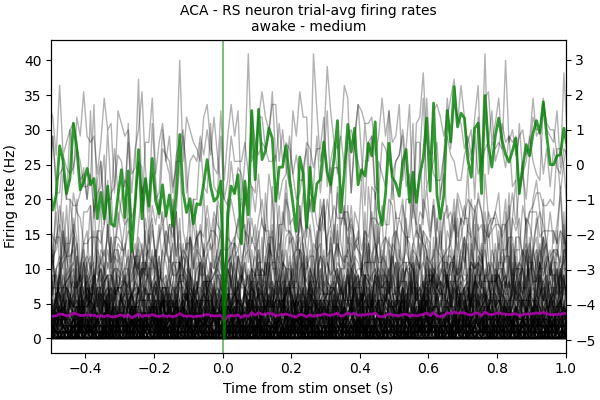

Text(0.5, 1.0, 'ACA - RS neuron trial-avg firing rates\nawake - medium')

In [159]:
plot_stim_level = 'medium'
plot_state = 'awake'
plot_region = 'ACA'
auc_win = [0.0, 0.5]

plot_time = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][0]
plot_traces = np.mean(mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][1], axis=2) # [time, units, trials]
pop_avg = np.mean(plot_traces, axis=1) # this avgs across units
pop_zscore = (pop_avg - np.mean(pop_avg[plot_time < 0])) / np.std(pop_avg[plot_time < 0])

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.plot(plot_time, plot_traces, color='k', linewidth=1, alpha=0.3)
ax.plot(plot_time, pop_avg, color='m', linewidth=2, alpha=0.8)
zax = ax.twinx()
zax.plot(plot_time, pop_zscore, color='g', linewidth=2, alpha=0.8)
# zax.plot(plot_time, np.abs(pop_zscore), color='b', linewidth=2, alpha=0.8)
# zax.plot(plot_time, zscore_avg, color='b', linewidth=2, alpha=0.8)

ax.set_xlim([-0.5, 1.0])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('{} - RS neuron trial-avg firing rates\n{} - {}'.format(plot_region, plot_state, plot_stim_level))

Shuffle event onset at the trial level, then find AUC after trial averaging

In [163]:
auc_win = [0.0, 0.5]
nn = 1000

start = time.time()
utimex = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][0]
alltraces = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][1] # [time, units, trials]

trialavgs = np.mean(alltraces, axis=2) # this avgs across trials
pop_avg = np.mean(trialavgs, axis=1) # this avgs across units
pop_zscore = (pop_avg - np.mean(pop_avg[utimex < 0])) / np.std(pop_avg[utimex < 0])
uinds = np.nonzero((utimex > auc_win[0]) & (utimex < auc_win[1]))[0]
unitauc = integrate.simps(np.abs(pop_zscore)[uinds], utimex[uinds], axis=0, even='last')
print(unitauc)
bluinds = np.nonzero((utimex > -auc_win[1]) & (utimex < -auc_win[0]))[0]
indsize = len(bluinds) + len(uinds)

shuffaucs = np.zeros((nn), dtype=float)
for shuffi in range(nn):
    trialstarts = np.random.uniform(low=0, high=alltraces.shape[0] - indsize, size=alltraces.shape[2]).astype(int)
    shufftrials = np.zeros((indsize, alltraces.shape[1], alltraces.shape[2]), dtype=float)
    for triali, startind in enumerate(trialstarts):
        shufftrials[:,:,triali] = alltraces[startind:startind+indsize,:,triali]
    avgavg = np.mean(np.mean(shufftrials, axis=2), axis=1)
    shuffz = (avgavg - np.mean(avgavg[:len(bluinds)])) / np.std(avgavg[:len(bluinds)])
    shuffaucs[shuffi] = integrate.simps(np.abs(shuffz[len(bluinds):]), utimex[uinds], axis=0, even='last')
    
end = time.time()
print(np.mean(shuffaucs))
print(np.sum(shuffaucs > unitauc) / nn)
print('Time: {:.2f} s'.format(end-start))

0.40699213798168404
0.43127385733122525
0.58
Time: 22.02 s


### Trial-by-trial plotting and metrics

<IPython.core.display.Javascript object>


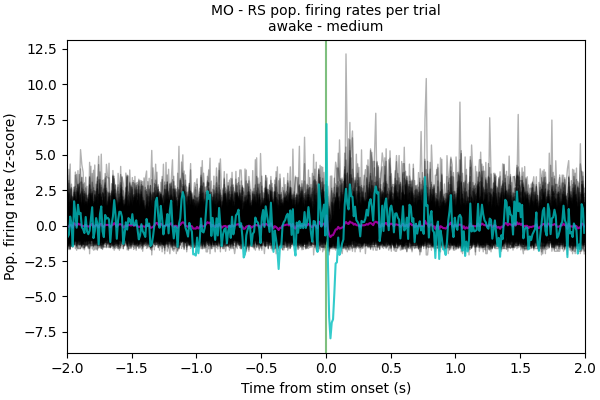

Text(0.5, 1.0, 'MO - RS pop. firing rates per trial\nawake - medium')

In [136]:
## Compare z-score for each unit to z-score for population ##
plot_stim_level = 'medium'
plot_state = 'awake'
plot_region = 'MO'

utimex = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][0]
allu_allt = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][1] # [time, units, trials]

## Find population FR, then z-score ##
popfr_allt = np.mean(allu_allt, 1)
popz_allt = (popfr_allt - np.mean(popfr_allt[utimex < 0, :], 0)) / np.std(popfr_allt[utimex < 0, :], 0)

popz_travg = np.mean(popz_allt, 1)
popzz = (popz_travg - np.mean(popz_travg[utimex < 0], 0)) / np.std(popz_travg[utimex < 0], 0)

## Plot ##
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.plot(utimex, popz_allt, color='k', linewidth=1, alpha=0.3)
ax.plot(utimex, popz_travg, color='m', linewidth=1.5, alpha=0.8)
ax.plot(utimex, popzz, color='c', linewidth=1.5, alpha=0.8)

ax.set_xlim([-2.0, 2.0])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pop. firing rate (z-score)')
ax.set_title('{} - RS pop. firing rates per trial\n{} - {}'.format(plot_region, plot_state, plot_stim_level))

Use a test to compare baseline and response AUC per trial

In [137]:
## Get AUC of population FR (not z-score) for each trial ##
auc_win = [0.0, 0.5]
respinds = np.nonzero((utimex > auc_win[0]) & (utimex < auc_win[1]))[0]
blinds = np.nonzero((utimex > -auc_win[1]) & (utimex < -auc_win[0]))[0]

respaucs = integrate.simps(popfr_allt[respinds], utimex[respinds], axis=0, even='last')
blaucs = integrate.simps(popfr_allt[blinds], utimex[blinds], axis=0, even='last')

## Wilcoxon ##
wstat, pval = stats.wilcoxon(x=respaucs, y=blaucs, zero_method='zsplit')
print(pval)

0.4732237490019421


In [138]:
respaucs = integrate.simps(np.abs(popz_allt[respinds]), utimex[respinds], axis=0, even='last')
blaucs = integrate.simps(np.abs(popz_allt[blinds]), utimex[blinds], axis=0, even='last')

## Wilcoxon ##
wstat, pval = stats.wilcoxon(x=respaucs, y=blaucs, zero_method='zsplit', alternative='greater')
print(pval)

0.0001018200780170223


In [135]:
## Compare 2 baseline periods ##
BL1 = [-1.1, -0.1]
BL2 = [-1.9, -0.9]
bl1inds = np.nonzero((utimex > BL1[0]) & (utimex < BL1[1]))[0]
bl2inds = np.nonzero((utimex > BL2[0]) & (utimex < BL2[1]))[0]

bl1aucs = integrate.simps(np.abs(popz_allt[bl1inds]), utimex[bl1inds], axis=0, even='last')
bl2aucs = integrate.simps(np.abs(popz_allt[bl2inds]), utimex[bl2inds], axis=0, even='last')

## Wilcoxon ##
wstat, pval = stats.wilcoxon(x=bl1aucs, y=bl2aucs, zero_method='zsplit', alternative='greater')
print(pval)

0.961136684260597


Use paired t-test to compare baseline to response

In [100]:
utimex = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][0]
ualltraces = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][1] # [time, units, trials]

pop_avg_trials = np.mean(ualltraces, axis=1) # this avgs across units

respinds = np.nonzero((plot_time > auc_win[0]) & (plot_time < auc_win[1]))[0]
blinds = np.nonzero((plot_time > -auc_win[1]) & (plot_time < -auc_win[0]))[0]

BLmeans = np.mean(pop_avg_trials[blinds,:], axis=0)
RESPmeans = np.mean(pop_avg_trials[respinds,:], axis=0)

paired_tstat, paired_pval = stats.ttest_rel(BLmeans, RESPmeans)
print(paired_pval)

0.1277976476159768


Use Kolmogorov-Smirnov test to compare the distributions of pre values and post values (SR thinks this violates the assumptions of the test)

In [94]:
respinds = np.nonzero((plot_time > auc_win[0]) & (plot_time < auc_win[1]))[0]
blinds = np.nonzero((plot_time > -auc_win[1]) & (plot_time < -auc_win[0]))[0]
ksstat, ksp = stats.ks_2samp(np.abs(pop_zscore)[respinds], np.abs(pop_zscore)[blinds])
if ksp < alpha:
    print('Reject null: the pre and post distributions are NOT identical, p={:.2E}'.format(ksp))
else:
    print('Do not reject null: the pre and post have the identical distributions.')

Do not reject null: the pre and post have the identical distributions.


Test it by comparing two baseline windows

In [69]:
BL1 = [-1.8, -1.0]
BL2 = [-0.9, -0.1]
respinds = np.nonzero((plot_time > BL1[0]) & (plot_time < BL1[1]))[0]
blinds = np.nonzero((plot_time > BL2[0]) & (plot_time < BL2[1]))[0]
ksstat, ksp = stats.ks_2samp(np.abs(pop_zscore)[respinds], np.abs(pop_zscore)[blinds])
if ksp < alpha:
    print('Reject null: the two baseline distributions are NOT identical, p={:.2E}'.format(ksp))
else:
    print('Do not reject null: the two baseline have identical distributions.')

Do not reject null: the two baseline have identical distributions.


Find AUC of baseline, 100 times, shuffling the baseline-start time

In [84]:
nn = 100
auc_win_length = auc_win[1] - auc_win[0]
baseline_starts = np.random.uniform(low=-2.5, high=0 - auc_win_length, size=nn)
BL_AUC = np.zeros_like(baseline_starts)
ss = time.time()
for ii, start_time in enumerate(baseline_starts):
    blinds = np.nonzero((plot_time > start_time) & (plot_time < start_time + auc_win_length))[0]
    BL_AUC[ii] = integrate.simps(np.abs(pop_zscore)[blinds], plot_time[blinds], axis=0, even='last')
ee = time.time()
print('Time = {:.2f} s'.format(ee-ss))
print('Unit response AUC = {:.2f}'.format(unitauc))
print('Mean/STD of baseline AUC: {:.2f} +/- {:.3f}'.format(np.mean(BL_AUC), np.std(BL_AUC)))
print('Bootstrapped p-value = {:.2E}'.format(np.sum(BL_AUC > unitauc) / len(BL_AUC)))

Time = 0.01 s
Unit response AUC = 3.98
Mean/STD of baseline AUC: 0.68 +/- 0.108
Bootstrapped p-value = 0.00E+00


In [71]:
np.max(BL_AUC)

1.6740225503511093

Look at LFP

<IPython.core.display.Javascript object>


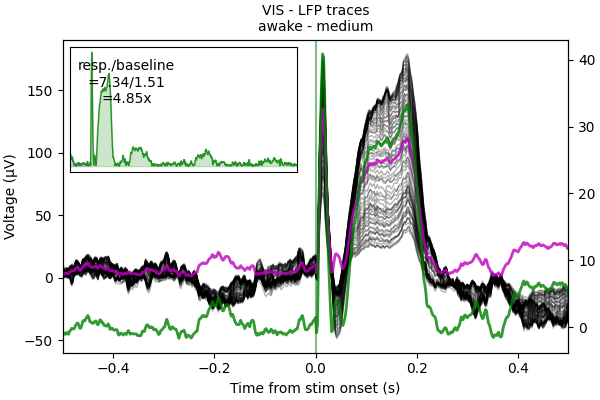

Text(0.25, 0.9, 'resp./baseline\n=7.34/1.51\n=4.85x')

In [37]:
plot_stim_level = 'medium'
plot_state = 'awake'
plot_region = 'VIS'
auc_win = [0, 2.0]

## LFP ##
ch_areas = np.array(LFPinfo[plot_region]['ch_areas'])
layer_mask = np.array([False if '1' in x else True for x in ch_areas])
LFP_timex = mdata['data']['LFP'][plot_stim_level][plot_state][plot_region][0]
LFP_traces = np.mean(mdata['data']['LFP'][plot_stim_level][plot_state][plot_region][1], axis=2)[:, layer_mask]
pop_LFP = np.mean(np.abs(LFP_traces), axis=1) # rectify LFP signals before average
#     pop_LFP = np.mean(LFP_traces, axis=1) # NO rectifying before average
pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_timex < 0])) / np.std(pop_LFP[LFP_timex < 0])
lfpinds = np.nonzero((LFP_timex > auc_win[0]) & (LFP_timex < auc_win[1]))[0]
lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_timex[lfpinds], axis=0, even='last')
bllfpinds = np.nonzero((LFP_timex > -auc_win[1]) & (LFP_timex < -auc_win[0]))[0]
bllfpauc = integrate.simps(np.abs(pop_LFP_zscore)[bllfpinds], LFP_timex[bllfpinds], axis=0, even='last')

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.plot(LFP_timex, LFP_traces, color='k', linewidth=1, alpha=0.3)
ax.plot(LFP_timex, pop_LFP, color='m', linewidth=2, alpha=0.8)
zax = ax.twinx()
zax.plot(LFP_timex, pop_LFP_zscore, color='g', linewidth=2, alpha=0.8)

ax.set_xlim([-0.5, 0.5])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (\u03bcV)')
ax.set_title('{} - LFP traces\n{} - {}'.format(plot_region, plot_state, plot_stim_level))

## Add an inset ##
axins = inset_axes(ax, width="45%", height="40%", loc=2)
axins.plot(LFP_timex, np.abs(pop_LFP_zscore), color='g', linewidth=1, alpha=0.8)
axins.fill_between(LFP_timex[lfpinds], np.abs(pop_LFP_zscore)[lfpinds], color='g', alpha=0.2)
axins.fill_between(LFP_timex[bllfpinds], np.abs(pop_LFP_zscore)[bllfpinds], color='k', alpha=0.2)
axins.set_xlim([-0.2, auc_win[1]])
axins.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
axins.annotate(
    'resp./baseline\n={:.2f}/{:.2f}\n={:.2f}x'.format(lfpauc, bllfpauc, lfpauc/bllfpauc), xy=(0.25, 0.9),
    xycoords='axes fraction', fontsize=10, ha='center', va='top'
)

Use Kolmogorov-Smirnov test to compare the distributions of pre values and post values

In [38]:
ksstat, ksp = stats.ks_2samp(np.abs(pop_LFP_zscore)[lfpinds], np.abs(pop_LFP_zscore)[bllfpinds])
print(ksstat)
if ksp < alpha:
    print('Reject null: the pre and post distributions are NOT identical, p={:.2E}'.format(ksp))
else:
    print('Do not reject null: the pre and post have the identical distributions.')

0.37037037037037035
Reject null: the pre and post distributions are NOT identical, p=2.38E-61


Find AUC of baseline, 100 times, shuffling the baseline-start time

In [39]:
nn = 1000
auc_win_length = auc_win[1] - auc_win[0]
baseline_starts = np.random.uniform(low=-2.5, high=0 - auc_win_length, size=nn)
BL_AUC = np.zeros_like(baseline_starts)
ss = time.time()
for ii, start_time in enumerate(baseline_starts):
    blinds = np.nonzero((LFP_timex > start_time) & (LFP_timex < start_time + auc_win_length))[0]
    BL_AUC[ii] = integrate.simps(np.abs(pop_LFP_zscore)[blinds], LFP_timex[blinds], axis=0, even='last')
ee = time.time()
print('Time = {:.2f} s'.format(ee-ss))

Time = 0.09 s


In [40]:
np.mean(BL_AUC)

1.263758237476241

In [41]:
np.std(BL_AUC) / np.sqrt(nn)

0.005004320853961487

In [42]:
print((lfpauc - np.mean(BL_AUC)) / np.std(BL_AUC))

38.3783144138495


In [43]:
print(np.sum(BL_AUC > lfpauc) / len(BL_AUC))

0.0


Find AUC of baseline-shuffled response: shuffling the timestamps

In [38]:
nn = 1000
prepostinds = np.nonzero((LFP_timex > -auc_win[1]) & (LFP_timex < auc_win[1]))[0]
preposttime = LFP_timex[prepostinds]
prepostLFP = np.abs(pop_LFP_zscore)[prepostinds]
aucinds = np.nonzero((preposttime > auc_win[0]) & (preposttime < auc_win[1]))[0]
shuffLFP = np.zeros((nn, len(prepostLFP)), dtype=float)
ss = time.time()
for ii in range(nn):
    LFPcopy = prepostLFP.copy()
    np.random.shuffle(LFPcopy)
    shuffLFP[ii,:] = LFPcopy
BL_AUC2 = integrate.simps(shuffLFP[:,aucinds], preposttime[aucinds], axis=1, even='last')
ee = time.time()
print('Time = {:.2f} s'.format(ee-ss))

Time = 0.14 s


In [39]:
np.mean(BL_AUC2)

0.9337105432220186

In [40]:
np.std(BL_AUC2)

0.017945131865692163

In [41]:
lfpauc

0.8849915541647418

<IPython.core.display.Javascript object>


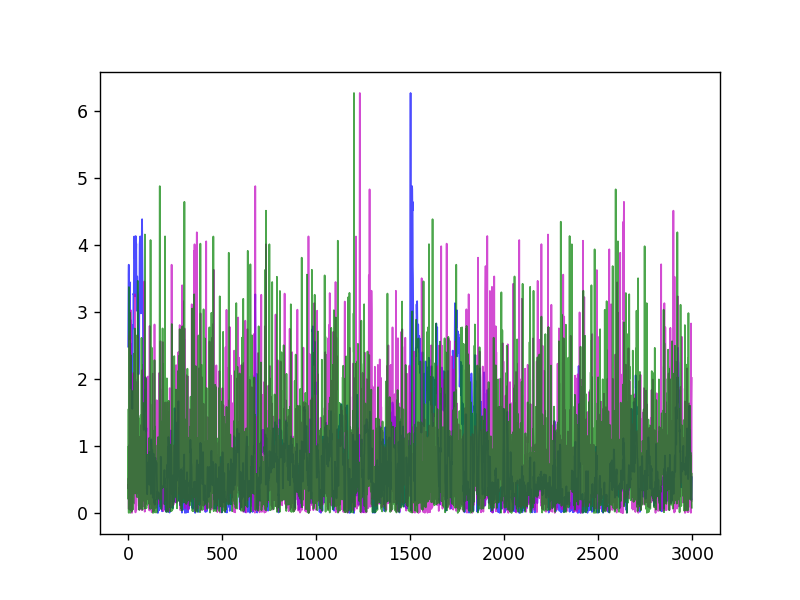

In [42]:
fig, ax = plt.subplots()
ax.plot(prepostLFP, color='b', linewidth=1, alpha=0.7)
ax.plot(shuffLFP[0,:], color='m', linewidth=1, alpha=0.7)
ax.plot(shuffLFP[2,:], color='g', linewidth=1, alpha=0.7)
# ax.plot(np.mean(shuffLFP, axis=0), color='m', alpha=0.7)

In [43]:
print((lfpauc - np.mean(BL_AUC2)) / np.std(BL_AUC2))

-2.714886099578831


In [44]:
print(np.sum(BL_AUC2 > lfpauc) / len(BL_AUC2))

0.997


Explain process with LFP: response AUC compared to baseline-shuffled AUC

<IPython.core.display.Javascript object>


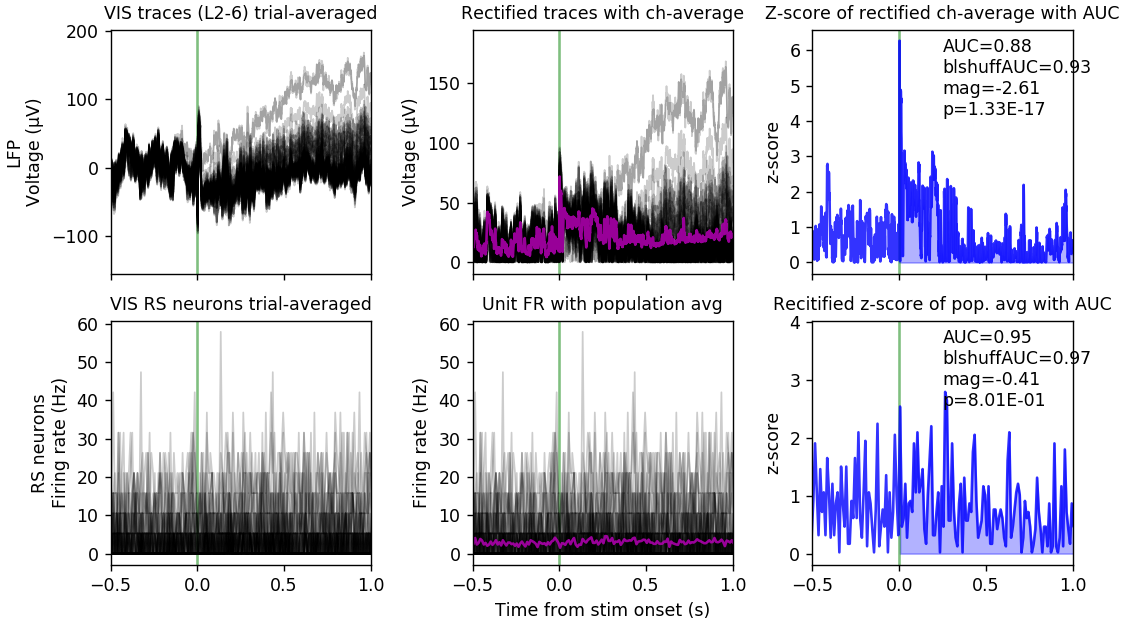

In [29]:
plot_stim_level = 'medium'
plot_state = 'resting'
plot_region = 'VIS'
auc_win = [0.0, 1.2]
nn = 1000 # number of shuffles

## LFP ##
ch_areas = np.array(LFPinfo[plot_region]['ch_areas'])
layer_mask = np.array([False if '1' in x else True for x in ch_areas])
LFP_timex = mdata['data']['LFP'][plot_stim_level][plot_state][plot_region][0]
LFP_traces = np.mean(mdata['data']['LFP'][plot_stim_level][plot_state][plot_region][1], axis=2)[:, layer_mask]
pop_LFP = np.mean(np.abs(LFP_traces), axis=1) # rectify LFP signals before average
pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_timex < 0])) / np.std(pop_LFP[LFP_timex < 0])
lfpinds = np.nonzero((LFP_timex > auc_win[0]) & (LFP_timex < auc_win[1]))[0]
bllfpinds = np.nonzero((LFP_timex > -auc_win[1]) & (LFP_timex < -auc_win[0]))[0]
lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_timex[lfpinds], axis=0, even='last')
## baseline shuffled auc ##
prepostinds = np.nonzero((LFP_timex > -auc_win[1]) & (LFP_timex < auc_win[1]))[0]
preposttime = LFP_timex[prepostinds]
aucinds = np.nonzero((preposttime > auc_win[0]) & (preposttime < auc_win[1]))[0]
shuffLFP = np.zeros((nn, len(prepostinds)), dtype=float)
for ii in range(nn):
    LFPcopy = np.abs(pop_LFP_zscore)[prepostinds].copy()
    np.random.shuffle(LFPcopy)
    shuffLFP[ii,:] = LFPcopy
blshuffLFPauc = integrate.simps(shuffLFP[:,aucinds], preposttime[aucinds], axis=1, even='last')
LFPmag = (lfpauc - np.mean(blshuffLFPauc)) / np.std(blshuffLFPauc)
LFPk, LFPpval = stats.ks_2samp(np.abs(pop_LFP_zscore)[lfpinds], np.abs(pop_LFP_zscore)[bllfpinds])
# LFPpval = np.sum(blshuffLFPauc > lfpauc) / nn

## Units ##
unit_timex = mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][0]
unit_traces = np.mean(mdata['data']['unit_frs'][plot_stim_level][plot_state][plot_region][1], axis=2) # [time, units, trials]
pop_avg = np.mean(unit_traces, axis=1)
pop_zscore = (pop_avg - np.mean(pop_avg[unit_timex < 0])) / np.std(pop_avg[unit_timex < 0])
uinds = np.nonzero((unit_timex > auc_win[0]) & (unit_timex < auc_win[1]))[0]
bluinds = np.nonzero((unit_timex > -auc_win[1]) & (unit_timex < -auc_win[0]))[0]
unitauc = integrate.simps(np.abs(pop_zscore)[uinds], unit_timex[uinds], axis=0, even='last')
## baseline shuffled auc ##
prepostinds = np.nonzero((unit_timex > -auc_win[1]) & (unit_timex < auc_win[1]))[0]
preposttime = unit_timex[prepostinds]
aucinds = np.nonzero((preposttime > auc_win[0]) & (preposttime < auc_win[1]))[0]
shuffMUA = np.zeros((nn, len(prepostinds)), dtype=float)
for ii in range(nn):
    MUAcopy = np.abs(pop_zscore)[prepostinds].copy()
    np.random.shuffle(MUAcopy)
    shuffMUA[ii,:] = MUAcopy
blshuffMUAauc = integrate.simps(shuffMUA[:,aucinds], preposttime[aucinds], axis=1, even='last')
FRmag = (unitauc - np.mean(blshuffMUAauc)) / np.std(blshuffMUAauc)
FRk, FRpval = stats.ks_2samp(np.abs(pop_zscore)[uinds], np.abs(pop_zscore)[bluinds])
# FRpval = np.sum(blshuffMUAauc > unitauc) / nn

fig, axs = plt.subplots(2, 3, figsize=(9, 5), sharex=True, constrained_layout=True)
### LFP ###
## Plot CTX traces ##
axs[0,0].set_title('{} traces (L2-6) trial-averaged'.format(plot_region))
axs[0,0].axvline(0, color='g', alpha=0.5)
axs[0,0].plot(LFP_timex, LFP_traces, color='k', linewidth=1, alpha=0.2)
axs[0,0].set_ylabel('LFP\nVoltage (\u03bcV)')
axs[0,0].set_xlim([-0.5, 1.0])

## Plot rectified CTX traces with avg ##
axs[0,1].set_title('Rectified traces with ch-average')
axs[0,1].axvline(0, color='g', alpha=0.5)
axs[0,1].plot(LFP_timex, np.abs(LFP_traces), color='k', linewidth=1, alpha=0.2)
axs[0,1].plot(LFP_timex, pop_LFP, color='m', linewidth=1.5, alpha=0.8)
axs[0,1].set_ylabel('Voltage (\u03bcV)')
# axs[0,1].set_xlabel('Time from stim onset (s)')

## Plot z-score of rectified avg ##
axs[0,2].set_title('Z-score of rectified ch-average with AUC')
axs[0,2].axvline(0, color='g', alpha=0.5)
axs[0,2].axvline(auc_win[1], color='k', linestyle='dashed', alpha=0.5)
axs[0,2].plot(LFP_timex, np.abs(pop_LFP_zscore), color='b', linewidth=1.5, alpha=0.8)
axs[0,2].fill_between(LFP_timex[lfpinds], np.abs(pop_LFP_zscore)[lfpinds], color='b', alpha=0.3)
axs[0,2].annotate(
    'AUC={:.2f}\nblshuffAUC={:.2f}\nmag={:.2f}\np={:.2E}'.format(lfpauc, np.mean(blshuffLFPauc), LFPmag, LFPpval),
    xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, ha='left', va='center'
)
axs[0,2].set_ylabel('z-score')

### UNITS ###
## Plot unit firing rates ##
axs[1,0].set_title('{} RS neurons trial-averaged'.format(plot_region))
axs[1,0].axvline(0, color='g', alpha=0.5)
axs[1,0].plot(unit_timex, unit_traces, color='k', linewidth=1, alpha=0.2)
axs[1,0].set_ylabel('RS neurons\nFiring rate (Hz)')
axs[1,0].set_xlim([-0.5, 1.0])

## Plot rectified CTX traces with avg ##
axs[1,1].set_title('Unit FR with population avg')
axs[1,1].axvline(0, color='g', alpha=0.5)
axs[1,1].plot(unit_timex, unit_traces, color='k', linewidth=1, alpha=0.2)
axs[1,1].plot(unit_timex, pop_avg, color='m', linewidth=1.5, alpha=0.8)
axs[1,1].set_ylabel('Firing rate (Hz)')
axs[1,1].set_xlabel('Time from stim onset (s)')

## Plot z-score of rectified avg ##
axs[1,2].set_title('Recitified z-score of pop. avg with AUC')
axs[1,2].axvline(0, color='g', alpha=0.5)
axs[1,2].axvline(auc_win[1], color='k', linestyle='dashed', alpha=0.5)
axs[1,2].plot(unit_timex, np.abs(pop_zscore), color='b', linewidth=1.5, alpha=0.8)
axs[1,2].fill_between(unit_timex[uinds], np.abs(pop_zscore)[uinds], color='b', alpha=0.3)
axs[1,2].annotate(
    'AUC={:.2f}\nblshuffAUC={:.2f}\nmag={:.2f}\np={:.2E}'.format(unitauc, np.mean(blshuffMUAauc), FRmag, FRpval),
    xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, ha='left', va='center'
)
axs[1,2].set_ylabel('z-score')

## Save ##
figname = 'demoAUCshuff_LFP-FR_{}-{}_{}_{}-{}.png'.format(group, mouse_num, plot_region, plot_state, plot_stim_level)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

#### Plot LFP and unit traces with rectified z-scores

<IPython.core.display.Javascript object>


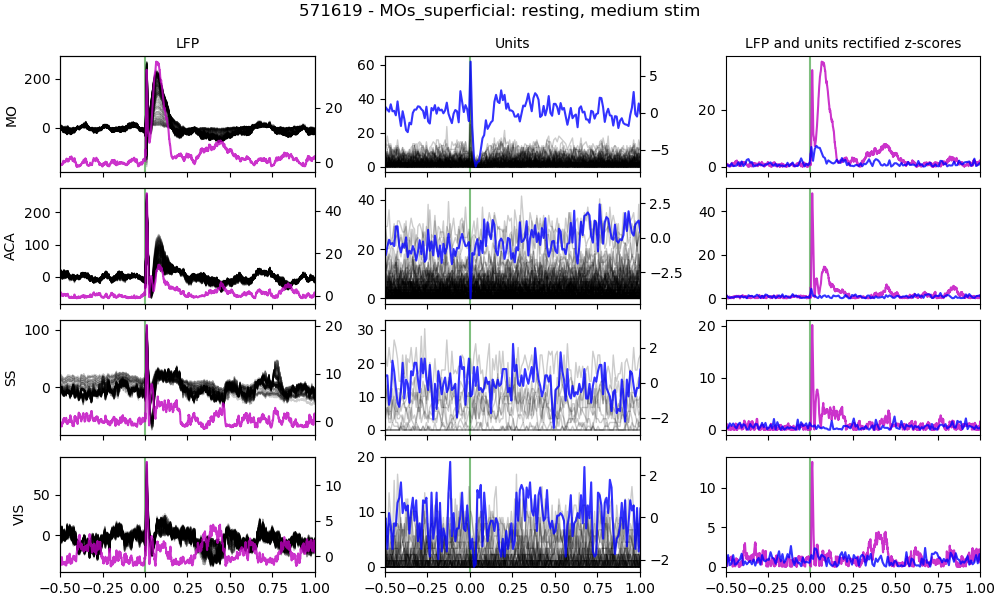

<IPython.core.display.Javascript object>


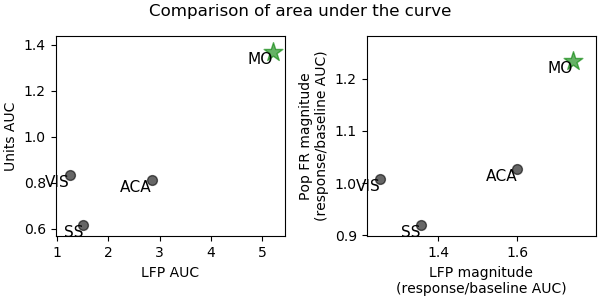

In [34]:
plot_stim_level = 'medium' # 'low' 'medium' 'high'
plot_state = 'resting' # 'awake' 'anesthetized'
auc_win = [0, 1.0]
nn = 1000

fig, axs = plt.subplots(len(ctx_regions), 3, figsize=(10, 6), sharex=True, constrained_layout=True)
figauc, aucaxs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

for rowi, regi in enumerate(ctx_regions):
    
    ## LFP ##
    ch_areas = np.array(LFPinfo[regi]['ch_areas'])
    layer_mask = np.array([False if '1' in x else True for x in ch_areas])
    LFP_timex = mdata['data']['LFP'][plot_stim_level][plot_state][regi][0]
    LFP_traces = np.mean(mdata['data']['LFP'][plot_stim_level][plot_state][regi][1], axis=2)[:, layer_mask]
    pop_LFP = np.mean(np.abs(LFP_traces), axis=1) # rectify LFP signals before average
    pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_timex < 0])) / np.std(pop_LFP[LFP_timex < 0])
    
    axs[rowi,0].axvline(0, color='g', alpha=0.5)
    axs[rowi,0].plot(LFP_timex, LFP_traces, color='k', linewidth=1, alpha=0.2)
    zlax = axs[rowi,0].twinx()
    zlax.plot(LFP_timex, pop_LFP_zscore, color='m', linewidth=1.5, alpha=0.8)
    axs[rowi,0].set_ylabel(regi)
    
    ## Units ##
    unit_timex = mdata['data']['unit_frs'][plot_stim_level][plot_state][regi][0]
    unit_traces = np.mean(mdata['data']['unit_frs'][plot_stim_level][plot_state][regi][1], axis=2) # [time, units]
    pop_avg = np.mean(unit_traces, axis=1)
    pop_zscore = (pop_avg - np.mean(pop_avg[unit_timex < 0])) / np.std(pop_avg[unit_timex < 0])
    
    axs[rowi,1].axvline(0, color='g', alpha=0.5)
    axs[rowi,1].plot(unit_timex, unit_traces, color='k', linewidth=1, alpha=0.2)
    zuax = axs[rowi,1].twinx()
    zuax.plot(unit_timex, pop_zscore, color='b', linewidth=1.5, alpha=0.8)
    
    ## Rectified z-scores ##
    axs[rowi,2].axvline(0, color='g', alpha=0.5)
    axs[rowi,2].plot(LFP_timex, np.abs(pop_LFP_zscore), color='m', linewidth=1.5, alpha=0.8)
    axs[rowi,2].plot(unit_timex, np.abs(pop_zscore), color='b', linewidth=1.5, alpha=0.8)
    
    ## Find AUC for both traces ##
    lfpinds = np.nonzero((LFP_timex > auc_win[0]) & (LFP_timex < auc_win[1]))[0]
    lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_timex[lfpinds], axis=0, even='last')
    uinds = np.nonzero((unit_timex > auc_win[0]) & (unit_timex < auc_win[1]))[0]
    unitauc = integrate.simps(np.abs(pop_zscore)[uinds], unit_timex[uinds], axis=0, even='last')
    
    ## baseline shuffled auc ##
    prepostinds1 = np.nonzero((LFP_timex > -auc_win[1]) & (LFP_timex < auc_win[1]))[0]
    preposttime1 = LFP_timex[prepostinds1]
    aucinds1 = np.nonzero((preposttime1 > auc_win[0]) & (preposttime1 < auc_win[1]))[0]
    shuffLFP = np.zeros((nn, len(prepostinds1)), dtype=float)
    prepostinds2 = np.nonzero((unit_timex > -auc_win[1]) & (unit_timex < auc_win[1]))[0]
    preposttime2 = unit_timex[prepostinds2]
    aucinds2 = np.nonzero((preposttime2 > auc_win[0]) & (preposttime2 < auc_win[1]))[0]
    shuffMUA = np.zeros((nn, len(prepostinds2)), dtype=float)
    for ii in range(nn):
        LFPcopy = np.abs(pop_LFP_zscore)[prepostinds1].copy()
        np.random.shuffle(LFPcopy)
        shuffLFP[ii,:] = LFPcopy
        MUAcopy = np.abs(pop_zscore)[prepostinds2].copy()
        np.random.shuffle(MUAcopy)
        shuffMUA[ii,:] = MUAcopy
    blshuffLFPauc = integrate.simps(shuffLFP[:,aucinds1], preposttime1[aucinds1], axis=1, even='last')
    bllfpauc = np.mean(blshuffLFPauc)
    LFPpval = np.sum(blshuffLFPauc > lfpauc) / nn
    blshuffMUAauc = integrate.simps(shuffMUA[:,aucinds2], preposttime2[aucinds2], axis=1, even='last')
    blunitauc = np.mean(blshuffMUAauc)
    FRpval = np.sum(blshuffMUAauc > unitauc) / nn
    
    if regi == stim_area:
        ptmk = '*'
    else:
        ptmk = '.'
    if (LFPpval > alpha) or (FRpval > alpha):
        dotc = 'k'
    else:
        dotc = 'g'
    aucaxs[0].scatter(lfpauc, unitauc, c=dotc, marker=ptmk, s=200, alpha=0.6)
    aucaxs[0].annotate(regi, (lfpauc, unitauc), fontsize=11, ha='right', va='top')
    
    aucaxs[1].scatter(lfpauc/bllfpauc, unitauc/blunitauc, c=dotc, marker=ptmk, s=200, alpha=0.6)
    aucaxs[1].annotate(regi, (lfpauc/bllfpauc, unitauc/blunitauc), fontsize=11, ha='right', va='top')
    
    
axs[0,0].set_xlim([-0.5, 1.0])
axs[0,0].set_title('LFP')
axs[0,1].set_title('Units')
axs[0,2].set_title('LFP and units rectified z-scores')
fig.suptitle('{} - {}: {}, {} stim'.format(mouse_num, group, plot_state, plot_stim_level))

aucaxs[0].set_xlabel('LFP AUC')
aucaxs[0].set_ylabel('Units AUC')
aucaxs[1].set_xlabel('LFP magnitude\n(response/baseline AUC)')
aucaxs[1].set_ylabel('Pop FR magnitude\n(response/baseline AUC)')
figauc.suptitle('Comparison of area under the curve')

## Save ##
bigfigname = 'LFP-units_Ztraces_{}-{}_{}-{}.png'.format(mouse_num, group, plot_state, plot_stim_level)
# fig.savefig(os.path.join(plotsdir, bigfigname), transparent=False)

scatfigname = 'Ztraces_comp_{}-{}_{}-{}.png'.format(mouse_num, group, plot_state, plot_stim_level)
# figauc.savefig(os.path.join(plotsdir, scatfigname), transparent=False)

## All subjects, measure AUC for population firing and LFP

In [17]:
## Parameters ##
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
apply_car = True

celltype = 'RS'
event_window = [-1.0, 1.0]
time_bin = 0.005 # size of time bins (s)
bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

auc_win = [0, 0.6]

I cannot load all subjects' EEG/LFP/units traces, too big for memory!

In [19]:
all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
   
        ## Load unit stats ##
        fn_units_stats = os.path.join(evoked_data_folder, 'units_info_wresp_' + group + '.csv')
        if os.path.exists(fn_units_stats):
        #     mdata['units_stats_df'] = pd.read_csv(fn_units_stats)
            full_unit_stats = pd.read_csv(fn_units_stats)
        else:
            print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})

        ## Load EEG traces ##
#         all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
#         EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
#         eeg_chs = np.arange(0, all_EEG_traces.shape[1])
#         GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
#         mdata['good_chs'] = GOOD_CHS

        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))

        ## Load unit data ##
        unit_info = pd.read_csv(os.path.join(evoked_data_folder, 'units_info_' + group + '.csv'))
        with open(os.path.join(evoked_data_folder, 'units_evoked_activity_' + group + '.pkl'), 'rb') as unit_file:
            unit_activity = pickle.load(unit_file)

        ## Load region LFP traces ONLY for regions with units AND LFP ##
        reg_allLFPtraces = {}
        reg_unit_info = {}
        for region in areas_of_interest.keys():
            regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
            if (len(regdf) > 8) and (region in LFPinfo.keys()):
                reg_unit_info[region] = regdf.sort_values(by='depth')
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            else:
                print('  {}: n={:d} -> not enough units, excluding'.format(region, len(regdf)))
        if len(reg_allLFPtraces) == 0:
            print('  Subject has no regions to analyze.\n')
            continue

        print('  Calculating AUC for LFP and population FR...\n')
        for leveli, parami in zip(current_levels, currents_list):
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if sweeps:
                    state_event_inds = []
                    for sweepi in sweeps:
                        eventinds = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=chtrials)
                        if len(eventinds) == 0:
                            continue
                        state_event_inds.append(eventinds)
                    state_event_inds = np.concatenate(state_event_inds)

                    ## Get evoked EEG traces ##
#                     EEG_traces = all_EEG_traces[:, :, state_event_inds]
#                     ## Apply common avg ##
#                     if apply_car:
#                         EEG_traces = EEG_traces - np.mean(EEG_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

                    for region in reg_allLFPtraces.keys():
                        stim_ctx = region == stim_area
                        ## Get evoked LFP traces and AUC ##
                        LFP_traces = reg_allLFPtraces[region][:, :, state_event_inds]
                        ch_areas = np.array(LFPinfo[region]['ch_areas'])
                        layer_mask = np.array([False if '1' in x else True for x in ch_areas])
                        ctxLFPtraces = np.mean(LFP_traces, axis=2)[:, layer_mask]
                        numLFPchs = ctxLFPtraces.shape[1]
                        pop_LFP = np.mean(np.abs(ctxLFPtraces), axis=1) # rectify LFP signals before average
                    #     pop_LFP = np.mean(LFP_traces, axis=1) # NO rectifying before average
                        pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_event_ts < 0])) / np.std(pop_LFP[LFP_event_ts < 0])
                        lfpinds = np.nonzero((LFP_event_ts > auc_win[0]) & (LFP_event_ts < auc_win[1]))[0]
                        lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_event_ts[lfpinds], axis=0, even='last')

                        ## Get unit traces and AUC ##
                        all_firing_rates = np.empty((len(reg_unit_info[region]), len(bins)-1)) * np.nan
                        for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                            spike_counts, edges = np.histogram(
                                np.concatenate(unit_activity[uniti][leveli][statei]['event_spikes']), bins)
                            all_firing_rates[uni, :] = (
                                spike_counts / (time_bin * unit_activity[uniti][leveli][statei]['trial_count']))
#                             all_unit_Z, non_nan_inds = get_zscore_fr(all_firing_rates, bins)
                        numunits = all_firing_rates.shape[0]
                        pop_avg = np.mean(all_firing_rates.T, axis=1)
                        pop_zscore = (pop_avg - np.mean(pop_avg[timex < 0])) / np.std(pop_avg[timex < 0])
                        uinds = np.nonzero((timex > auc_win[0]) & (timex < auc_win[1]))[0]
                        unitauc = integrate.simps(np.abs(pop_zscore)[uinds], timex[uinds], axis=0, even='last')
                            
                        ## Gather all stats ##
                        sub_stats = [
                            group, mouse_num, stim_area, stim_depth, region, stim_ctx, leveli, statei,
                            numLFPchs, lfpauc, numunits, unitauc
                        ]
                        all_subs_stats.append(sub_stats)

        ### After each subject, delete common variables ###
        del stim_log
#         del all_EEG_traces, EEG_event_timestamps
        del reg_allLFPtraces, LFP_event_ts, LFPinfo
        del unit_activity, unit_info, reg_unit_info
        
## Create stats dataframe ##
all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'stim_level', 'state', 'LFPchs', 'LFPauc',
    'numunits', 'FRauc'
])

MOs_superficial

 546655
  ACA: n=0 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding
  VIS: n=5 -> not enough units, excluding
  MO-TH: n=3 -> not enough units, excluding
  Getting evoked traces...

 575102
  SS: n=0 -> not enough units, excluding
  MO-TH: n=0 -> not enough units, excluding
  Getting evoked traces...

 571619
  Getting evoked traces...

MOs_deep

 551399
  VIS: n=0 -> not enough units, excluding
  Getting evoked traces...

 551397
  VIS: n=0 -> not enough units, excluding
  Getting evoked traces...

 569062
  VIS: n=0 -> not enough units, excluding
  Getting evoked traces...

 569068
  ACA: n=2 -> not enough units, excluding
  VIS: n=0 -> not enough units, excluding
  Getting evoked traces...

 569069
  SS: n=0 -> not enough units, excluding
  Getting evoked traces...

 569064
  SS: n=3 -> not enough units, excluding
  MO-TH: n=0 -> not enough units, excluding
  Getting evoked traces...

 569073
  Getting evoked traces...

 571619
  Getting evoke

In [20]:
all_subs_stats_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,stim_level,state,LFPchs,LFPauc,numunits,FRauc
0,MOs_superficial,546655,MO,superficial,MO,True,low,awake,115,13.730542,18,1.101182
1,MOs_superficial,546655,MO,superficial,MO,True,low,anesthetized,115,1.927576,18,0.631422
2,MOs_superficial,546655,MO,superficial,MO,True,medium,awake,115,12.588827,18,1.451744
3,MOs_superficial,546655,MO,superficial,MO,True,medium,anesthetized,115,3.828025,18,0.476645
4,MOs_superficial,546655,MO,superficial,MO,True,high,awake,115,16.312304,18,1.327664


#### Make a scatter plot (stim vs. non-stim with superfical/deep coloring)

In [39]:
ctx_stim = {'stim': True, 'nonstim': False}
depth_color = {'superficial': 'm', 'deep': 'b'}

<IPython.core.display.Javascript object>


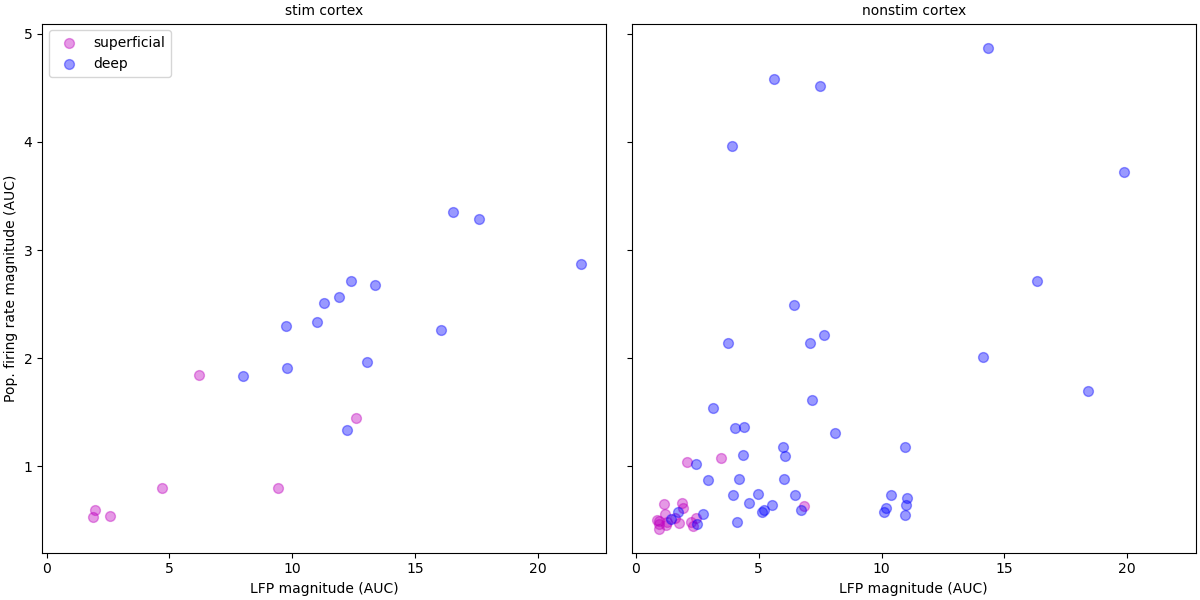

In [31]:
plot_state = 'awake'
plot_stim_level = 'medium'

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)

sclegend = []
sclabels = []
for ii, (ax, (labeli, stimTF)) in enumerate(zip(axs, ctx_stim.items())):
    for depthi, dcolori in depth_color.items():
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_depth'] == depthi) &
            (all_subs_stats_df['state'] == plot_state) &
            (all_subs_stats_df['stim_cortex'] == stimTF) &
            (all_subs_stats_df['stim_level'] == plot_stim_level)
        ]
        scat = ax.scatter(df['LFPauc'].values, df['FRauc'].values, c=dcolori, marker='o', s=50, alpha=0.4)
        if ii == 0:
            sclegend.append(scat)
            sclabels.append(depthi)
    ax.set_title('{} cortex'.format(labeli))
    ax.set_xlabel('LFP magnitude (AUC)')

axs[0].set_ylabel('Pop. firing rate magnitude (AUC)')
axs[0].legend(sclegend, sclabels, loc='upper left')

## Save ##
figname = 'AUCscatter_LFP-FR_allmice_stim-nonstim_{}-{}_{}.png'.format(plot_state, plot_stim_level, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## All subjects, finding responsiveness metrics in 3 windows

In [17]:
## Parameters ##
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
celltype = 'RS'
current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']
response_window = {
    'early': [0.002, 0.025],
    'mid': [0.025, 0.15],
    'late': [0.15, 0.3],
}
LFP_zlim = 3

In [18]:
all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print('{}\n'.format(group))
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit stats ##
        fn_units_stats = os.path.join(evoked_data_folder, 'units_info_wresp_' + group + '.csv')
        if os.path.exists(fn_units_stats):
#             mdata['units_stats_df'] = pd.read_csv(fn_units_stats)
            full_unit_stats = pd.read_csv(fn_units_stats)
        else:
            print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))
            continue
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        
        ## Load region LFP traces ONLY for regions with units AND LFP ##
        reg_LFPtraces = {}
        reg_unit_stats = {}
        for region in ctx_regions:
            reg_stats = full_unit_stats[((full_unit_stats['parent'] == region) & (full_unit_stats['cell_type'] == celltype))]
            if (len(reg_stats) > 8) and (region in LFPinfo.keys()):
                reg_unit_stats[region] = reg_stats
                reg_LFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            else:
                print('  {}: n={:d} -> not enough units, excluding'.format(region, len(reg_stats)))
        if len(reg_LFPtraces) == 0:
            print('  Subject has no regions to analyze.\n')
            continue
        
        for leveli, parami in zip(current_levels, currents_list):
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if sweeps:
                    state_event_inds = []
                    for sweepi in sweeps:
                        eventinds = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=chtrials)
                        if len(eventinds) == 0:
                            continue
                        state_event_inds.append(eventinds)
                    state_event_inds = np.concatenate(state_event_inds)

                    for region in reg_LFPtraces.keys():
                        stim_ctx = region == stim_area
                        
                        ## Get evoked LFP traces ##
                        ch_areas = np.array(LFPinfo[region]['ch_areas'])
                        layer_mask = np.array([False if '1' in x else True for x in ch_areas])
                        ctx_traces = np.mean(reg_LFPtraces[region][:, :, state_event_inds], axis=2)[:, layer_mask]
                        globpow = np.std(ctx_traces, axis=1)
                        zglobpow = (globpow - np.mean(globpow[LFP_event_ts < 0])) / np.std(globpow[LFP_event_ts < 0])
                        erpsig = np.where((zglobpow - LFP_zlim) >= 0, (zglobpow - LFP_zlim), 0.)
                        
                        ## Analyze response windows ##
                        for wini, window in response_window.items():
                            ## AUC of LFP traces ##
                            wininds = np.nonzero((LFP_event_ts >= window[0]) & (LFP_event_ts < window[1]))[0]
                            auc = integrate.simps(erpsig[wininds], LFP_event_ts[wininds], axis=0, even='last')
                            ## Get region units stats ##
                            dfi = reg_unit_stats[region][(
                                (reg_unit_stats[region]['stim_level'] == leveli) &
                                (reg_unit_stats[region]['state'] == statei) &
                                (reg_unit_stats[region]['response_stage'] == wini)
                            )]
                            resp_fract = np.sum(dfi['response_type'].values != 'ns') / len(dfi)
                            
                            sub_stats = [
                                group, mouse_num, stim_depth, region, stim_ctx, leveli, statei, wini, resp_fract, auc
                            ]
                            all_subs_stats.append(sub_stats)
        
        ### After each subject, delete common variables ###
        del stim_log, reg_LFPtraces, LFP_event_ts, LFPinfo, full_unit_stats, reg_unit_stats
        print('')
        
all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_depth', 'region', 'stim_cortex', 'stim_level', 'state', 'window', 'unit_respfr', 'LFP_auc'
])

MOs_superficial

 546655
  ACA: n=0 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding

 575102
  SS: n=0 -> not enough units, excluding

 571619

MOs_deep

 551399
  VIS: n=0 -> not enough units, excluding

 551397
  VIS: n=0 -> not enough units, excluding

 569062
  VIS: n=0 -> not enough units, excluding

 569068
  VIS: n=0 -> not enough units, excluding

 569069
  SS: n=0 -> not enough units, excluding

 569064

 569073

 571619

SSp_superficial

 571620

 586466
  VIS: n=0 -> not enough units, excluding

 590479
  VIS: n=0 -> not enough units, excluding

 590480

SSp_deep

 569073

 569072

 571620

 586466
  VIS: n=0 -> not enough units, excluding

 590479
  VIS: n=0 -> not enough units, excluding

 590480



In [19]:
all_subs_stats_df.head()

,group,mouse,stim_depth,region,stim_cortex,stim_level,state,window,unit_respfr,LFP_auc
0,MOs_superficial,546655,superficial,MO,True,low,awake,early,0.000000,0.604650
1,MOs_superficial,546655,superficial,MO,True,low,awake,mid,0.166667,8.109728
2,MOs_superficial,546655,superficial,MO,True,low,awake,late,0.166667,3.182750
3,MOs_superficial,546655,superficial,VIS,False,low,awake,early,0.000000,0.097246
4,MOs_superficial,546655,superficial,VIS,False,low,awake,mid,0.200000,0.266287


### Scatter plot

In [20]:
ctx_stim = {'stim': True, 'nonstim': False}

<IPython.core.display.Javascript object>


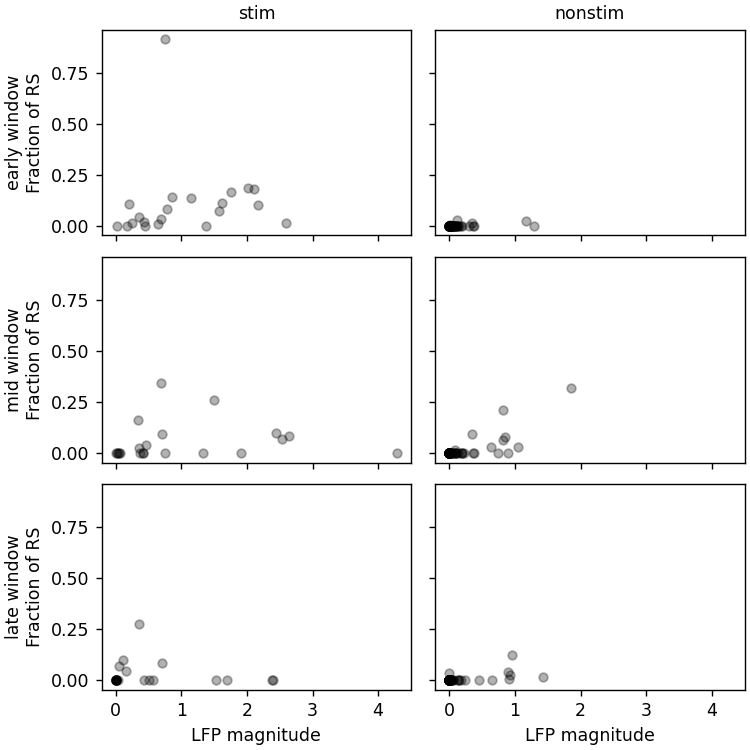

In [27]:
plot_depth = None # superficial, deep, or None=all combined
plot_state = 'awake'
plot_level = 'medium'

fig, axs = plt.subplots(3, 2, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)

for rowi, windi in enumerate(response_window.keys()):
    for coli, (labeli, stimTF) in enumerate(ctx_stim.items()):
        if plot_depth:
            df = all_subs_stats_df[
                (all_subs_stats_df['stim_depth'] == plot_depth) &
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
        else:
            df = all_subs_stats_df[
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
        axs[rowi,coli].scatter(df['LFP_auc'].values, df['unit_respfr'].values, c='k', marker='o', s=25, alpha=0.3)
        if coli == 0:
            axs[rowi,coli].set_ylabel('{} window\nFraction of {}'.format(windi, celltype))
        if rowi == 0:
            axs[rowi,coli].set_title(labeli)
        if rowi == axs.shape[0] - 1:
            axs[rowi,coli].set_xlabel('LFP magnitude')

## Save ##
figname = 'LFP-units_allmice_stim-nonstim_{}-{}_{}.png'.format(plot_state, plot_level, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

In [28]:
axs.shape

(3, 2)